In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Question 1

The exercise asks - programmatically download all the data for green taxis and show how many rows and columns there are.

In order to programmatically download all the green taxi data I decided to use wget.  Originally I had tried doing:

```
import pandas as pd
df = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')
df.to_csv("green_taxi.csv")
```

However this proved to be very, very slow.  So after about 5 minutes of waiting, I decided to switch to wget.  I set up `data.txt` with the relevant url and set up `download_data.sh` which calls `wget` with xargs on the data.  The script looks like this:

`cat data.txt | xargs -n 1 -P 4 wget -c -P data/`

In this script arbitrary data is loaded wget, via xargs from the file `data.txt`.  This way, if I want to expand the analysis to include other taxi cab datasets, it is easy to do so.  I parallelize the task with the flags `-n` and `-P`.  The `-n` flag tells wget how to process urls, in this case one at a time, because I passed in `1` to the flag.  The `-P` flag tells `wget` how many processes to run concurrently, in this case `4` because we want it to move fast! I wanted to be a little careful, so I did the following:

```
from multiprocessing import cpu_count
nCores = cpu_count()
print(nCores)
```

This told me how many cores I have on my machine and thus the optimal number of processes.  This isn't a hard or strict rule.  For `Python` programs, using multiprocessing this tends to become more of a sticking point for performance.  Because `wget` is so fast (and not written in `Python`) there isn't a noticible difference.  

In [2]:
green = pd.read_csv("data/green_tripdata_2015-09.csv")

In [3]:
green.shape

(1494926, 21)

Now that I've downloaded and loaded the data into memory, I see that there are:

* 1494926 rows
* 21 columns


In [8]:
green.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

Here are the column names available

# Question 2

Now that we have a sense of the types of columns, let's dive into question 2 - 

For this question we plot a histogram of the number of the trip distance and report any structure and hypotheses about the structure.


In [4]:
print(green["Trip_distance"].min())
print(green["Trip_distance"].max())

0.0
603.1


The above gives us a sense of the range of values for trip distance.  In order to really put this into context, we'll need the units for these numbers.

For this I turned to the data dictionary associated with the data set, found here:

`http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf`

It turns out `Trip_distance` is defined as:

_The elapsed trip distance in miles reported by the taximeter._

So we can say these numbers are in miles.  My guess is that 0.0 is when someone got in a cab, decided they didn't want to go anywhere and got out of the cab, after the cab drive already started the meter.

We can verify this by looking to see if there was a charge associated with: 

`Trip_distance == 0`

-475.0
500.0


(array([3.57366211e-05, 1.78683106e-05, 3.57366211e-05, 1.60814795e-04,
        3.25203252e-03, 5.55704458e-03, 6.96864111e-04, 2.50156348e-04,
        1.42946484e-04, 1.07209863e-04]),
 array([-475. , -377.5, -280. , -182.5,  -85. ,   12.5,  110. ,  207.5,
         305. ,  402.5,  500. ]),
 <a list of 10 Patch objects>)

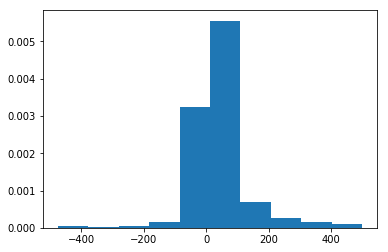

In [4]:
no_distance = green[green["Trip_distance"] == 0]
fare_amounts = list(set(no_distance["Fare_amount"]))
print(min(fare_amounts))
print(max(fare_amounts))
plt.hist(fare_amounts, density=True)

Interestingly the fair amounts range from -475 to 500.  Just to make sure we are on the same page, `Fare_amount` is in dollars.  I have no good sense of what a negative fare means in this dataset, so I'm going to drop any records with a negative fare amount. 

In [3]:
green = green[green["Fare_amount"] >= 0]

Just to be sure this is the only issue, let's look at the ranges for all the other real valued columns too


In [6]:
numeric_data = green._get_numeric_data()
for column in numeric_data.columns: 
    print(column)
    print("Min", min(green[column]))
    print("Max", max(green[column]))
    print()

VendorID
Min 1
Max 2

RateCodeID
Min 1
Max 99

Pickup_longitude
Min -83.31907653808595
Max 0.0

Pickup_latitude
Min 0.0
Max 43.177261352539055

Dropoff_longitude
Min -83.42784118652342
Max 0.0

Dropoff_latitude
Min 0.0
Max 42.79934310913085

Passenger_count
Min 0
Max 9

Trip_distance
Min 0.0
Max 603.1

Fare_amount
Min 0.0
Max 580.5

Extra
Min -0.72
Max 12.0

MTA_tax
Min 0.0
Max 0.5

Tip_amount
Min 0.0
Max 300.0

Tolls_amount
Min 0.0
Max 95.75

Ehail_fee
Min nan
Max nan

improvement_surcharge
Min 0.0
Max 0.3

Total_amount
Min 0.0
Max 581.3

Payment_type
Min 1
Max 5

Trip_type 
Min 1.0
Max 2.0



It looks like `Extra` which is defined as:

_Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges._

Has some negative values.  Also Ehail_fee appears to be only `nan`.  Let's verify this:

In [8]:
green["Ehail_fee"].unique()

array([nan])

This tells us we should drop `Ehail_fee` and let's also segment `Extra` to be only positive values.

In [4]:
green = green[green["Extra"] >= 0]
green.drop("Ehail_fee", axis=1, inplace=True)

Now we are ready for our first histogram!

(array([0.36964233, 0.20854991, 0.13369146, 0.08290189, 0.05674022,
        0.04104937, 0.03023886, 0.02015981, 0.01455313, 0.01150014,
        0.00842837, 0.00621096, 0.00457479, 0.00354461, 0.00275512,
        0.0017403 , 0.00191697, 0.00180175]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 <a list of 18 Patch objects>)

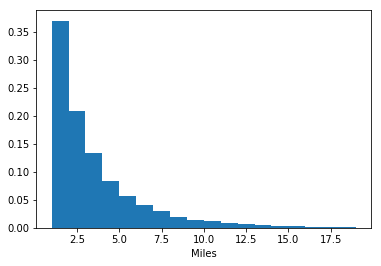

In [7]:
bins = list(range(1,20,1))
plt.xlabel("Miles")
plt.hist(green["Trip_distance"], bins=bins, density=True)

First, let's look at the array that was output above the histogram.  This is because I set the density flag to `True` and shows us the density of each bin.  We can think of this like an area under the curve, where the sum of the area must equal 1.

As you can see, the majority of the trips occur between 0 and 1 miles for green taxi cabs.  And as you go further distances the frequence of each distance bin drops off exponentially.  

There are a few reasons I think this is the case:

1. Because cost is a function of distance, as cost increases there will be fewer people willing to pay the higher prices.
2. The subway system is good, so if long distance travel is required, most folks will take the subway instead.


In [5]:
green.to_csv("green_taxi_cleaned.csv", index=False)